In [2]:
# !mkdir -p v1.0-mini
# !tar -xzf 'nuScenes v1.0 mini.tgz' -C v1.0-mini

In [ ]:
!pip install -U 'nbformat>=4.2.0'

In [ ]:
!uv pip install ultralytics inference'[yolo-world]' "git+https://github.com/openai/CLIP.git"

In [4]:
from nuscenes.nuscenes import NuScenes
from pathlib import Path
from utils import read_image, show_image, read_lidar, show_lidar_pointcloud
from pyquaternion import Quaternion

In [5]:
nuscenes_root_dir = Path('./v1.0-mini')

## Get samples for one of the scenes

In [ ]:
nusc = NuScenes(version='v1.0-mini', dataroot=nuscenes_root_dir)

In [84]:
my_scene = nusc.scene[0]
my_scene_samples_tokens = [sample['token'] for sample in nusc.sample if sample['scene_token'] == my_scene['token']]
sample_token = my_scene_samples_tokens[3]  #'e0845f5322254dafadbbed75aaa07969'

### CAM_FRONT data for the sample

In [ ]:
from ultralytics import YOLO
from inference.models.yolo_world.yolo_world import YOLOWorld
import supervision as sv
import cv2

# Initialize a YOLO-World model
model = YOLOWorld(model_id='yolo_world/v2-x') 

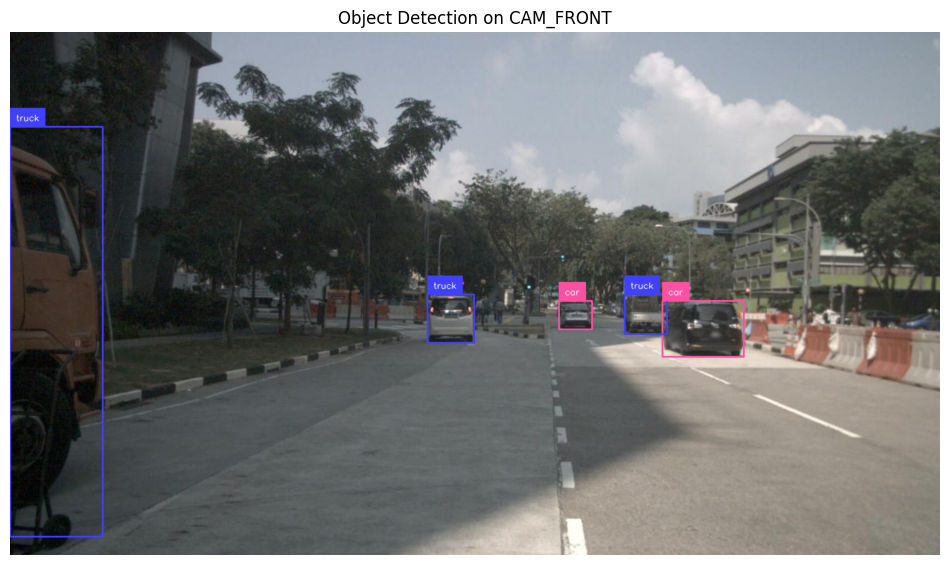

In [75]:
from matplotlib import pyplot as plt

sample_info = nusc.get('sample', sample_token)

classes = [
        "car", "truck", "bus", "motorcycle", "bicycle", 
        "person", "traffic light", "stop sign", "fire hydrant", "cone"
    ]

def detect_objects_in_camera_image(nusc, sample_info, camera_channel, nuscenes_root_dir, model: YOLOWorld, iou=0.5, confidence=0.3):
    cam_data = nusc.get('sample_data', sample_info['data'][camera_channel])
    cam_path = nuscenes_root_dir / cam_data['filename']

    # Read the image
    image = cv2.imread(str(cam_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Run YOLO-World model on the image with text prompts
    results = model.infer(
        image,
        text=classes,
        confidence=confidence,  # Confidence threshold
        iou=iou          # IoU threshold for NMS
    )
    
    return image, results


def display_detections(results, image):
    # Extract detections
    detections = sv.Detections.from_inference(results)
    labels = [classes[class_id] for class_id in detections.class_id]


    # Create annotator for visualization
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Annotate the image with bounding boxes
    annotated_image = box_annotator.annotate(
        scene=image.copy(),
        detections=detections
    )

    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        labels=labels
    )
    
    return annotated_image, detections

camera_channel = 'CAM_FRONT'
image, results = detect_objects_in_camera_image(
    nusc, sample_info, camera_channel, nuscenes_root_dir, model
)

annotated_image, detections = display_detections(results, image)

plt.figure(figsize=(12, 8))
plt.imshow(annotated_image)
plt.axis('off')
plt.title(f'Object Detection on {camera_channel}')
plt.show()

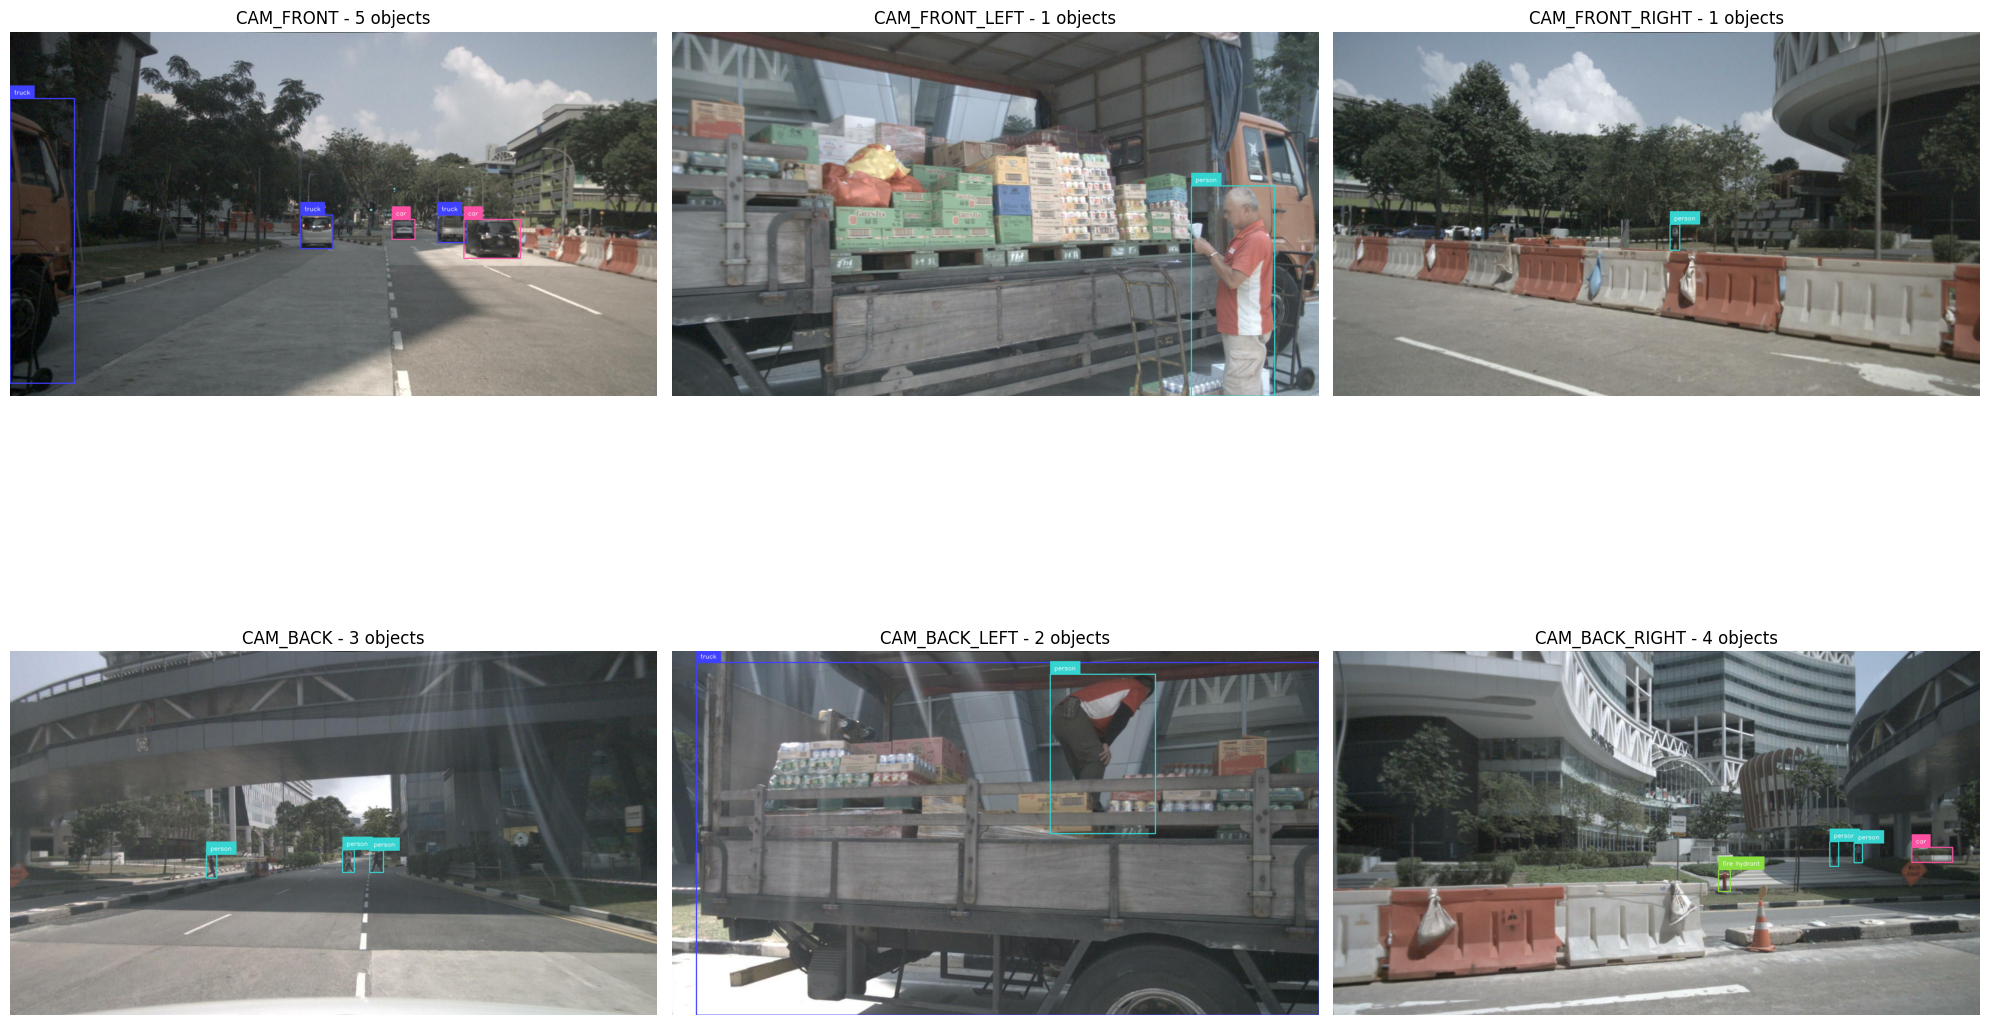

In [76]:
camera_channels = [
    'CAM_FRONT', 
    'CAM_FRONT_LEFT', 
    'CAM_FRONT_RIGHT', 
    'CAM_BACK', 
    'CAM_BACK_LEFT', 
    'CAM_BACK_RIGHT'
]

plt.figure(figsize=(20, 15))

for idx, camera_channel in enumerate(camera_channels):
    image, results = detect_objects_in_camera_image(
        nusc, sample_info, camera_channel, nuscenes_root_dir, model
    )
    
    annotated_image, detections = display_detections(results, image)
    
    plt.subplot(2, 3, idx+1)
    plt.imshow(annotated_image)
    plt.title(f'{camera_channel} - {len(detections)} objects')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Download the SAM model checkpoint if it doesn't exist
import os
import requests
from tqdm import tqdm

def download_file(url, destination):
    """
    Download a file from a URL to a destination with progress bar
    """
    if os.path.exists(destination):
        print(f"File already exists at {destination}")
        return
    
    print(f"Downloading {url} to {destination}")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(destination, 'wb') as file, tqdm(
        desc=os.path.basename(destination),
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
    
    print(f"Download complete: {destination}")

# Download SAM ViT-H model
sam_checkpoint_path = "sam_vit_h_4b8939.pth"
sam_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
download_file(sam_url, sam_checkpoint_path)


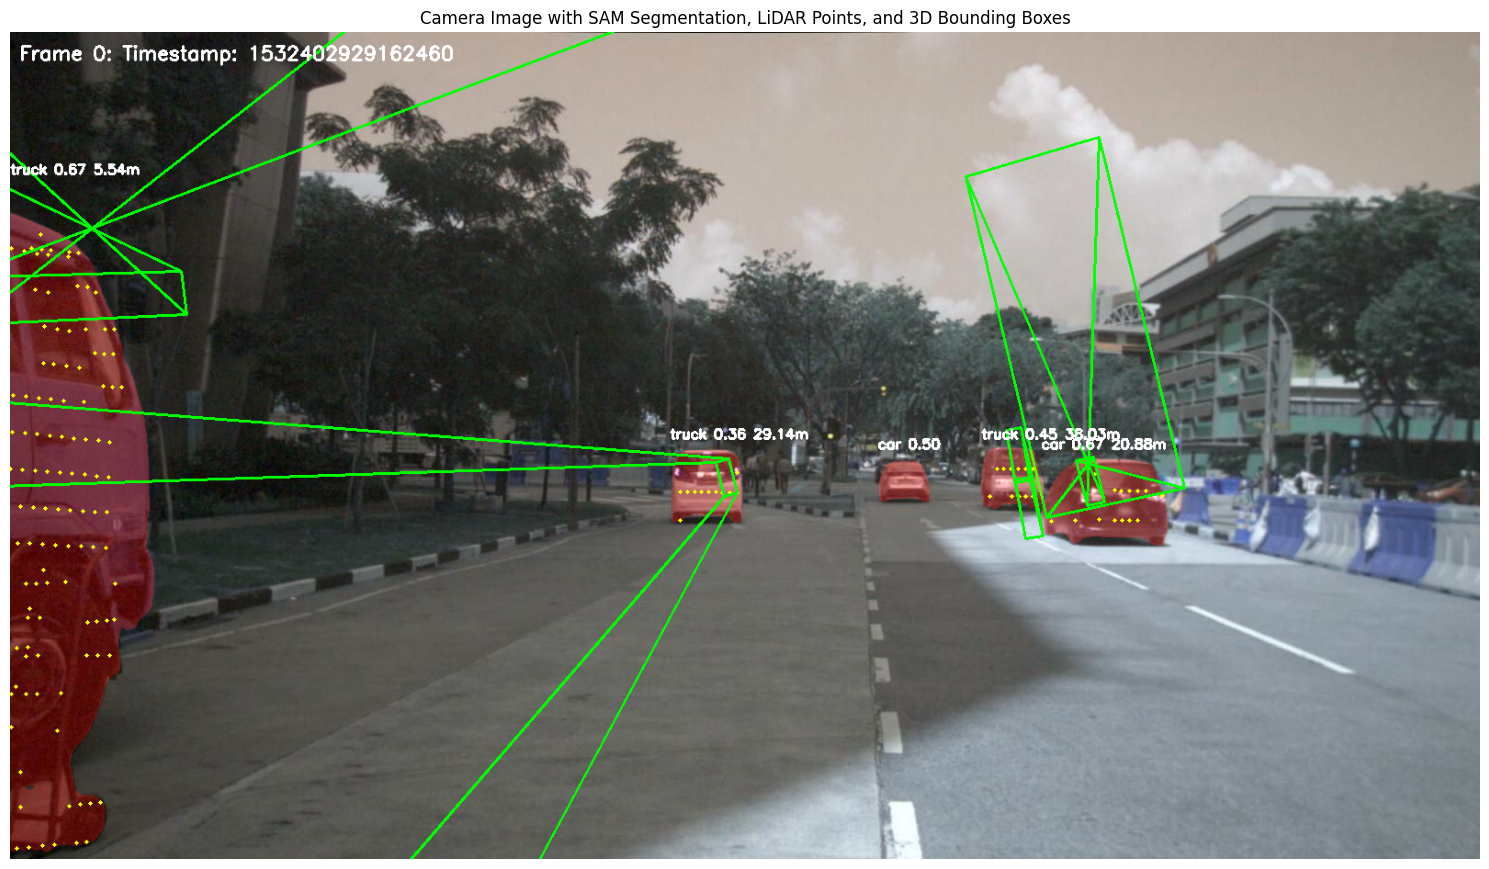

In [93]:
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor

def project_lidar_to_camera(lidar_points_sensor_row, cam_calib, lidar_calib):
    R_lidar_to_ego = Quaternion(lidar_calib['rotation']).rotation_matrix
    T_lidar_to_ego_row = np.array(lidar_calib['translation']).reshape(1, 3)
    
    lidar_points_ego_row = lidar_points_sensor_row @ R_lidar_to_ego.T + T_lidar_to_ego_row

    R_cam_to_ego = Quaternion(cam_calib['rotation']).rotation_matrix
    T_cam_in_ego_row = np.array(cam_calib['translation']).reshape(1, 3) # Position of camera origin in ego coords

    points_camera_frame_row = (lidar_points_ego_row - T_cam_in_ego_row) @ R_cam_to_ego
    
    # Points too close to the camera plane or behind are filtered.
    in_front_cam_mask = points_camera_frame_row[:, 2] > 0.1 
    points_in_cam_frame_filtered = points_camera_frame_row[in_front_cam_mask]
    
    if points_in_cam_frame_filtered.shape[0] == 0:
        return np.empty((0, 2)), np.empty((0,)), np.empty((0,3)), np.array([], dtype=bool)
    K_cam_intrinsic = np.array(cam_calib['camera_intrinsic'])
    
    # Project points to 2D image plane
    projected_hom_row = points_in_cam_frame_filtered @ K_cam_intrinsic.T
    
    # Perspective divide: divide x and y by z to get image coordinates
    projected_points_img = projected_hom_row[:, :2] / projected_hom_row[:, 2, np.newaxis]
    
    depths_in_cam_frame = projected_hom_row[:, 2] # Or points_in_cam_frame_filtered[:, 2]

    return projected_points_img, depths_in_cam_frame, points_in_cam_frame_filtered, in_front_cam_mask


def process_sample_for_camera(nusc, sample_token, camera_channel, nuscenes_root_dir, model, i):
    current_sample = nusc.get('sample', sample_token)
    
    lidar_top_data = nusc.get('sample_data', current_sample['data']['LIDAR_TOP'])
    lidar_calibration = nusc.get('calibrated_sensor', lidar_top_data['calibrated_sensor_token'])
    
    lidar_path = nuscenes_root_dir / lidar_top_data['filename']
    lidar_points = read_lidar(lidar_path)
    
    cam_data = nusc.get('sample_data', current_sample['data'][camera_channel])
    cam_calibration = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    
    image, results = detect_objects_in_camera_image(
        nusc, current_sample, camera_channel, nuscenes_root_dir, model
    )
    
    # Get detections but don't draw 2D boxes yet
    _, detections = display_detections(results, image.copy())
    
    # Create a clean copy of the image for our 3D visualization
    annotated_image_with_lidar = image.copy()
    
    projected_points, depths, points_in_cam_frame, in_front_cam_mask = project_lidar_to_camera(
        lidar_points[:, :3],
        cam_calibration,
        lidar_calibration
    )
    
    image_height, image_width = annotated_image_with_lidar.shape[:2]
    in_image_mask = (
        (projected_points[:, 0] >= 0) & (projected_points[:, 0] < image_width) &
        (projected_points[:, 1] >= 0) & (projected_points[:, 1] < image_height)
    )
    
    visible_projected_points = projected_points[in_image_mask]
    visible_depths = depths[in_image_mask]
    visible_points_3d = points_in_cam_frame[in_image_mask]
    
    # Initialize SAM predictor
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_path)
    sam.to(device="cuda" if torch.cuda.is_available() else "cpu")
    sam_predictor = SamPredictor(sam)
    sam_predictor.set_image(image)
    
    # Process each detection to estimate distance and create 3D boxes
    object_distances = []
    updated_labels = []
    label_annotator = sv.LabelAnnotator()
    
    for j in range(len(detections)):
        box = detections.xyxy[j]
        class_id = detections.class_id[j]
        confidence = detections.confidence[j]
        label_text = f"{classes[class_id]} {confidence:.2f}"
        
        # Get box center for SAM
        box_center = np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])
        
        # Use SAM to get a mask for the object
        masks, scores, _ = sam_predictor.predict(
            point_coords=box_center.reshape(1, 2),
            point_labels=np.array([1]),  # 1 means foreground
            box=box.reshape(1, 4),
            multimask_output=False
        )
        
        # Get the best mask
        mask = masks[0]
        
        # Visualize the mask with a colored overlay
        mask_color = np.array([0, 0, 255], dtype=np.uint8)  # Red for the mask
        mask_overlay = np.zeros_like(annotated_image_with_lidar)
        mask_overlay[mask] = mask_color
        annotated_image_with_lidar = cv2.addWeighted(
            annotated_image_with_lidar, 1.0, 
            mask_overlay, 0.3, 0
        )
        
        # Find LiDAR points that fall within the mask
        points_in_mask = []
        depths_in_mask = []
        points_3d_in_mask = []
        
        for pt_idx in range(visible_projected_points.shape[0]):
            x, y = int(visible_projected_points[pt_idx, 0]), int(visible_projected_points[pt_idx, 1])
            if 0 <= x < image_width and 0 <= y < image_height and mask[y, x]:
                points_in_mask.append(visible_projected_points[pt_idx])
                depths_in_mask.append(visible_depths[pt_idx])
                points_3d_in_mask.append(visible_points_3d[pt_idx])
        
        points_in_mask = np.array(points_in_mask) if points_in_mask else np.empty((0, 2))
        depths_in_mask = np.array(depths_in_mask) if depths_in_mask else np.empty(0)
        points_3d_in_mask = np.array(points_3d_in_mask) if points_3d_in_mask else np.empty((0, 3))
        
        current_label = label_text
        if len(depths_in_mask) > 5:  # Ensure we have enough points for a meaningful estimate
            # Estimate distance (median depth of points in the mask)
            distance = np.median(depths_in_mask)
            object_distances.append(distance)
            current_label += f" {distance:.2f}m"
            
            # Draw LiDAR points inside the mask
            for pt_idx in range(points_in_mask.shape[0]):
                cv2.circle(annotated_image_with_lidar, 
                          (int(lidar_points_in_box[pt_idx, 0]), int(lidar_points_in_box[pt_idx, 1])), 
                          2, (255, 0, 0), -1)  # Blue for points in box
        else:
            object_distances.append(float('inf'))  # No points in box
        
        updated_labels.append(current_label)
    
    # Annotate with updated labels (including distances)
    if len(detections) > 0:
        annotated_image_with_lidar = label_annotator.annotate(
            scene=annotated_image_with_lidar, 
            detections=detections, 
            labels=updated_labels
        )
    
    timestamp = cam_data['timestamp']
    cv2.putText(annotated_image_with_lidar, 
               f"Frame {i}: Timestamp: {timestamp}", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    return annotated_image_with_lidar

example = process_sample_for_camera(nusc, sample_token, 'CAM_FRONT', nuscenes_root_dir, model, 0)

# Display the example processed image with LiDAR points and object detection
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(example, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Camera Image with LiDAR Points and Object Detection')
plt.tight_layout()
plt.show()


In [82]:
import numpy as np
import os
import imageio
import os
from tqdm import tqdm

output_dir = "camera_videos"
os.makedirs(output_dir, exist_ok=True)

scene_token = sample_info['scene_token']
scene = nusc.get('scene', scene_token)
sample_tokens = []

current_sample_token = scene['first_sample_token']
while current_sample_token != '':
    sample_tokens.append(current_sample_token)
    current_sample = nusc.get('sample', current_sample_token)
    current_sample_token = current_sample['next']

for camera_channel in tqdm(camera_channels, desc="Processing cameras"):
    camera_frames = []
    
    camera_dir = os.path.join(output_dir, camera_channel)
    os.makedirs(camera_dir, exist_ok=True)
    
    for i, sample_token in enumerate(tqdm(sample_tokens, desc=f"Processing {camera_channel} frames", leave=False)):
        annotated_image_with_lidar = process_sample_for_camera(
            nusc, sample_token, camera_channel, nuscenes_root_dir, model, i
        )
        
        frame_path = os.path.join(camera_dir, f"frame_{i:03d}.jpg")
        cv2.imwrite(frame_path, cv2.cvtColor(annotated_image_with_lidar, cv2.COLOR_RGB2BGR))
        
        camera_frames.append(annotated_image_with_lidar)
    
    # Create GIF for this camera
    gif_path = os.path.join(output_dir, f"{camera_channel}.gif")
    with imageio.get_writer(gif_path, mode='I', duration=1) as writer:
        for frame in camera_frames:
            writer.append_data(frame)
    
    print(f"Created GIF for {camera_channel}: {gif_path}")

print("All camera GIFs have been created in the 'camera_videos' directory.")


Processing cameras:  17%|█▋        | 1/6 [00:16<01:24, 16.81s/it]

Created GIF for CAM_FRONT: camera_videos/CAM_FRONT.gif


Processing cameras:  33%|███▎      | 2/6 [00:33<01:07, 16.86s/it]

Created GIF for CAM_FRONT_LEFT: camera_videos/CAM_FRONT_LEFT.gif


Processing cameras:  50%|█████     | 3/6 [00:50<00:50, 16.84s/it]

Created GIF for CAM_FRONT_RIGHT: camera_videos/CAM_FRONT_RIGHT.gif


Processing cameras:  67%|██████▋   | 4/6 [01:07<00:33, 16.73s/it]

Created GIF for CAM_BACK: camera_videos/CAM_BACK.gif


Processing cameras:  83%|████████▎ | 5/6 [01:23<00:16, 16.74s/it]

Created GIF for CAM_BACK_LEFT: camera_videos/CAM_BACK_LEFT.gif


Processing cameras: 100%|██████████| 6/6 [01:40<00:00, 16.79s/it]

Created GIF for CAM_BACK_RIGHT: camera_videos/CAM_BACK_RIGHT.gif
All camera GIFs have been created in the 'camera_videos' directory.


In [ ]:
def combine_gifs_into_grid(gif_paths, output_path, grid_size=(2, 3), duration=0.2):
    """
    Combine multiple GIFs into a single grid GIF.
    
    Args:
        gif_paths (list): List of paths to input GIFs
        output_path (str): Path to save the combined GIF
        grid_size (tuple): Size of the grid (rows, cols)
        duration (float): Duration of each frame in seconds
    """
    # Read all input GIFs
    gifs = [imageio.get_reader(path) for path in gif_paths]
    
    # Get dimensions of the first frame of the first GIF
    first_frame = gifs[0].get_data(0)
    frame_height, frame_width = first_frame.shape[:2]
    
    # Calculate total grid dimensions
    grid_height = frame_height * grid_size[0]
    grid_width = frame_width * grid_size[1]
    
    # Create output writer
    with imageio.get_writer(output_path, mode='I', duration=duration) as writer:
        # Process each frame
        for frame_idx in range(len(gifs[0])):
            # Create empty grid frame
            grid_frame = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)
            
            # Place each GIF's frame in the grid
            for i, gif in enumerate(gifs):
                if frame_idx < len(gif):
                    frame = gif.get_data(frame_idx)
                    row = i // grid_size[1]
                    col = i % grid_size[1]
                    grid_frame[row*frame_height:(row+1)*frame_height, 
                             col*frame_width:(col+1)*frame_width] = frame
            
            # Write the combined frame
            writer.append_data(grid_frame)
    
    # Close all input GIFs
    for gif in gifs:
        gif.close()

# After creating individual GIFs, combine them into a single grid GIF
gif_paths = [os.path.join(output_dir, f"{channel}.gif") for channel in camera_channels]
combined_gif_path = os.path.join(output_dir, "combined_cameras.gif")
combine_gifs_into_grid(gif_paths, combined_gif_path)
print(f"Created combined GIF: {combined_gif_path}")